# Import Libraries

In [1]:
import os
import librosa
import parselmouth
import librosa
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import IPython
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
import matplotlib.pyplot as plt

# Feature Extraction

## Load Audio File

In [2]:
audio_path = r"C:\Users\danis\OneDrive\Documents\Year 3\CPC 353\Assignment 2\IEMOCAP\Session1\dialog\wav\Ses01F_impro01.wav"
y, sr = librosa.load(audio_path, sr=None, mono=True)

## Define Sliding Window

In [3]:
frame_length = 0.02  # 20ms in seconds
hop_length = 0.01    # 10ms overlap in seconds
n_fft = int(frame_length * sr)
hop_samples = int(hop_length * sr)

## Extract MFCC Features

In [4]:
mfccs = librosa.feature.mfcc(
    y=y,
    sr=sr,
    n_mfcc=13,        # Standard 13 MFCC coefficients
    n_fft=n_fft,
    hop_length=hop_samples,
    win_length=n_fft,
    n_mels=20,
    fmax=sr//2 
)
mfccs = mfccs.T      # Transpose to (num_frames, 13)

## Extract F0 Features

In [5]:
sound = parselmouth.Sound(audio_path)
pitch = sound.to_pitch(
    time_step=hop_length,   # 10ms hop to match MFCCs
    pitch_floor=75,         # Minimum F0 (Hz)
    pitch_ceiling=600       # Maximum F0 (Hz)
)
f0 = pitch.selected_array['frequency']  # Extract F0 values

# Ensure F0 and MFCCs have the same number of frames
min_frames = min(len(f0), len(mfccs))
f0 = f0[:min_frames]
mfccs = mfccs[:min_frames]

## Create Dataframe

In [41]:
time = np.arange(0, min_frames) * hop_length  # Time axis
df = pd.DataFrame({
    'Time (s)': time,
    'F0 (Hz)': f0
})
# Add MFCC columns
for i in range(mfccs.shape[1]):
    df[f'MFCC_{i+1}'] = mfccs[:, i]

print("Top 10 rows of extracted features:")
print(df.head(10))

Top 10 rows of extracted features:
   Time (s)  F0 (Hz)      MFCC_1    MFCC_2     MFCC_3    MFCC_4     MFCC_5  \
0      0.00      0.0  -65.697075  1.481197 -10.268813 -3.626295   1.431140   
1      0.01      0.0  -87.786110  3.518946 -12.236429 -4.196713  -5.200883   
2      0.02      0.0 -101.543533 -0.469183 -10.085785  4.237269 -10.969513   
3      0.03      0.0 -101.772598 -1.623724 -16.295685  0.629845  -3.990727   
4      0.04      0.0 -103.109138  2.672153 -13.896694  1.447683  -7.562066   
5      0.05      0.0 -116.495483  5.920802  -7.808731  2.928702  -9.143061   
6      0.06      0.0 -125.060966  7.832814  -9.828442  7.360909  -0.105583   
7      0.07      0.0 -129.828232  4.619879  -6.689894  0.961384  -2.504561   
8      0.08      0.0 -134.140610  5.653681   0.655518  5.445251  -4.841560   
9      0.09      0.0 -132.686234  5.656480  -6.337479  8.914671   2.363195   

     MFCC_6     MFCC_7    MFCC_8     MFCC_9   MFCC_10   MFCC_11   MFCC_12  \
0  3.997905  -4.470235  0.166

## Visualize Features

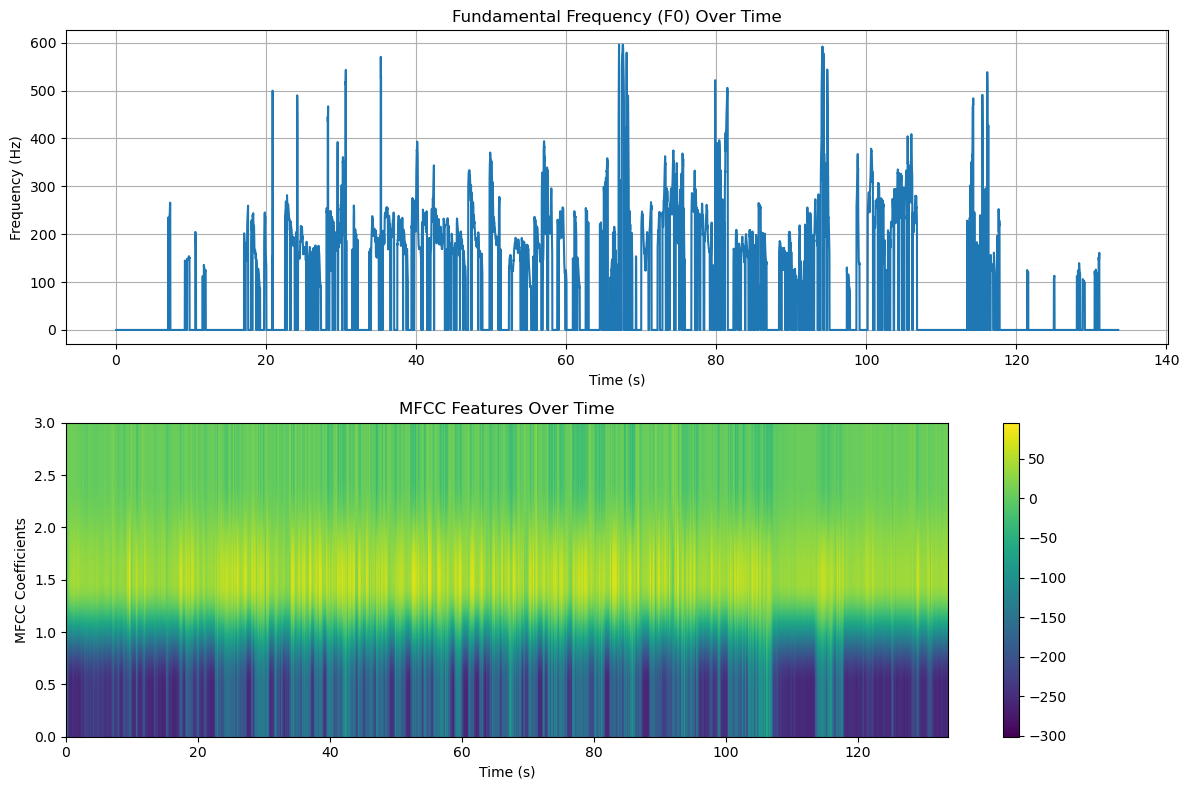

In [7]:
plt.figure(figsize=(12, 8))

# Plot F0
plt.subplot(2, 1, 1)
plt.plot(time, f0, label='F0 (Pitch)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Fundamental Frequency (F0) Over Time')
plt.grid()

# Plot MFCCs (first 3 coefficients)
plt.subplot(2, 1, 2)
plt.imshow(mfccs[:, :3].T, aspect='auto', origin='lower', cmap='viridis',
           extent=[time[0], time[-1], 0, 3])
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.title('MFCC Features Over Time')
plt.colorbar()

plt.tight_layout()
plt.show()

# Data Preprocessing

## Feature Extraction (F0 + MFCC)

In [1]:
def extract_features(wav_path):
    """Extract F0 and MFCC features with librosa and parselmouth."""
    # Load audio with native sample rate
    y, sr = librosa.load(wav_path, sr=None, mono=True)
    
    # Sliding window parameters (20ms frames, 10ms overlap)
    frame_length = 0.02  # 20ms
    hop_length = 0.01    # 10ms
    n_fft = int(frame_length * sr)
    hop_samples = int(hop_length * sr)

    # Extract MFCCs with adjusted parameters
    mfccs = librosa.feature.mfcc(
        y=y, sr=sr,
        n_mfcc=13,       # 13 coefficients
        n_fft=n_fft,
        hop_length=hop_samples,
        win_length=n_fft,
        n_mels=40,       
        fmax=sr//2       
    ).T 

    # Extract F0 using Praat (parselmouth)
    sound = parselmouth.Sound(wav_path)
    pitch = sound.to_pitch(
        time_step=hop_length,
        pitch_floor=75,
        pitch_ceiling=600
    )
    f0 = pitch.selected_array['frequency']
    f0 = np.nan_to_num(f0)  

    # Align F0 and MFCCs
    min_frames = min(len(f0), len(mfccs))
    time = np.arange(min_frames) * hop_length
    df = pd.DataFrame({'Time (s)': time, 'F0 (Hz)': f0[:min_frames]})
    
    # Add MFCC columns
    for i in range(mfccs.shape[1]):
        df[f'MFCC_{i+1}'] = mfccs[:min_frames, i]

    return df

## RTTM Parser

In [9]:
def parse_rttm(rttm_path):
    """Parse RTTM file into speaker segments."""
    segments = []
    with open(rttm_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if parts[0] == 'SPEAKER':
                start = float(parts[3])
                duration = float(parts[4])
                segments.append({
                    'start': start,
                    'end': start + duration,
                    'speaker': parts[7]
                })
    return segments

## Create Label

In [10]:
def get_dominant_speaker(frame_start, frame_end, segments):
    """Find speaker with maximum overlap in time frame."""
    max_overlap = 0
    dominant_speaker = None
    for seg in segments:
        overlap_start = max(frame_start, seg['start'])
        overlap_end = min(frame_end, seg['end'])
        overlap = max(0, overlap_end - overlap_start)
        if overlap > max_overlap:
            max_overlap = overlap
            dominant_speaker = seg['speaker']
    return dominant_speaker

def generate_labels(df, segments):
    """Add binary speaker change labels."""
    speakers = []
    for t in df['Time (s)']:
        frame_end = t + 0.02  # 20ms frame duration
        speaker = get_dominant_speaker(t, frame_end, segments)
        speakers.append(speaker)
    
    # Generate labels (1=change, 0=no change)
    labels = [0]  # First frame has no previous speaker
    for i in range(1, len(speakers)):
        labels.append(1 if speakers[i] != speakers[i-1] else 0)
    
    df['label'] = labels
    return df

## Dataset Processing & Splitting

In [11]:
def process_dataset(base_path):
    """Process all sessions and split into train/val/test."""
    train_dfs, val_dfs, test_dfs = [], [], []

    for session in [1, 2, 3, 4, 5]:
        # Get all WAV files in session
        wav_dir = os.path.join(base_path, f"Session{session}", "dialog", "wav")
        wav_files = glob.glob(os.path.join(wav_dir, "*.wav"))

        for wav_path in wav_files:
            # Feature extraction
            df = extract_features(wav_path)
            
            # Load corresponding RTTM
            rttm_filename = os.path.basename(wav_path).replace(".wav", ".rttm")
            rttm_path = os.path.join(base_path, "reference", rttm_filename)
            segments = parse_rttm(rttm_path)
            
            # Label generation
            df_labeled = generate_labels(df, segments)
            df_labeled['session'] = session
            
            # Split data
            if session <= 3:
                train_dfs.append(df_labeled)
            elif session == 4:
                val_dfs.append(df_labeled)
            elif session == 5:
                test_dfs.append(df_labeled)

    return pd.concat(train_dfs), pd.concat(val_dfs), pd.concat(test_dfs)


## Execute Data Splitting

In [12]:
# Path configuration
base_path = "C:/Users/danis/OneDrive/Documents/Year 3/CPC 353/Assignment 2/IEMOCAP/"

# Process dataset
train_df, val_df, test_df = process_dataset(base_path)

# Display sample output
print("\nTraining data sample:")
print(train_df[['Time (s)', 'F0 (Hz)', 'MFCC_1', 'label', 'session']].head(10))

# Save datasets
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)


Training data sample:
   Time (s)  F0 (Hz)      MFCC_1  label  session
0      0.00      0.0 -101.951813      0        1
1      0.01      0.0 -134.292648      0        1
2      0.02      0.0 -151.282944      0        1
3      0.03      0.0 -154.408524      0        1
4      0.04      0.0 -154.771667      0        1
5      0.05      0.0 -175.420303      0        1
6      0.06      0.0 -185.670639      0        1
7      0.07      0.0 -191.671310      0        1
8      0.08      0.0 -197.523270      0        1
9      0.09      0.0 -197.790421      0        1


In [47]:
train_df.head(10)

,Time (s),F0 (Hz),MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13,label,session
0,0.00,0.0,-101.95181,5.397984,-21.744383,1.807256,-3.337846,11.078530,-13.149544,4.988782,-11.502361,9.583952,-18.406979,-3.360378,-12.206785,0,1
1,0.01,0.0,-134.29265,10.040823,-25.971020,0.245366,-15.977922,15.899746,-18.607494,3.292958,-24.103016,7.554322,-6.115422,-3.313083,-10.866217,0,1
2,0.02,0.0,-151.28294,4.277017,-21.588928,11.554088,-21.963812,-5.429545,-20.985500,7.684005,-3.734243,8.777816,-3.680333,7.444886,-4.545526,0,1
3,0.03,0.0,-154.40852,0.684568,-33.095703,7.203958,-12.424139,14.373639,-16.888947,6.329384,-12.736864,2.348029,-16.568628,-0.696620,-6.785871,0,1
4,0.04,0.0,-154.77167,6.481535,-28.637600,6.199042,-17.623562,6.485778,-21.294530,0.887389,-10.579296,9.537805,-8.651960,5.336406,2.252241,0,1
5,0.05,0.0,-175.42030,11.850512,-21.508211,8.483230,-21.134160,8.124491,-25.380230,-6.056619,-14.966249,4.115447,-4.832050,8.692806,-5.194295,0,1
6,0.06,0.0,-185.67064,14.877316,-17.379646,16.654057,-5.320429,16.275002,-15.866995,-5.005380,-7.776954,4.552423,-9.231988,0.744648,1.758477,0,1
7,0.07,0.0,-191.67131,12.334043,-16.051693,8.102257,-10.010769,17.601460,-13.464979,-1.741220,-11.218579,12.241043,-5.342149,2.768612,-8.984798,0,1
8,0.08,0.0,-197.52327,13.758703,-6.489442,14.909149,-12.711416,16.444944,-4.151545,14.287906,-11.358492,-0.420469,-10.703797,6.776672,-3.776050,0,1
9,0.09,0.0,-197.79042,10.865670,-14.411890,18.141869,-5.947227,15.969468,-19.367641,1.957000,-10.381897,6.866095,-10.583970,-8.263850,-15.016640,0,1


In [48]:
val_df.head(10)

,Time (s),F0 (Hz),MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13,label,session
0,0.00,0.0,-95.02039,5.069171,-20.700844,0.582746,-16.462324,11.590738,-8.957568,7.556021,2.469644,-2.095230,-10.437778,-0.553110,-10.824623,0,4
1,0.01,0.0,-141.49144,1.037327,-19.432034,2.574711,-21.446968,11.844392,-15.341185,2.353452,-2.040010,7.865458,-11.594715,1.568467,-2.109650,0,4
2,0.02,0.0,-172.87418,-13.797353,-28.347681,-0.204700,-22.933578,13.233002,-10.987598,9.057774,4.211434,9.066674,-11.376305,10.459163,3.227012,0,4
3,0.03,0.0,-166.49896,-6.667121,-35.435867,2.945784,-20.661507,16.953848,-5.564576,14.156309,1.466760,8.048146,-14.518969,6.984457,-2.152228,0,4
4,0.04,0.0,-183.15515,-3.678980,-25.094536,0.288261,-24.416016,12.185204,-14.560526,17.407763,2.105415,5.194788,-13.516860,-1.095141,-4.161116,0,4
5,0.05,0.0,-198.91177,-13.069370,-25.800606,5.716919,-26.158173,7.351943,-8.835213,13.517263,-0.171155,3.388905,-11.662827,-0.462492,-5.652958,0,4
6,0.06,0.0,-203.25740,-9.308219,-18.762695,1.844967,-21.841156,11.911230,-0.618181,21.287548,0.198315,9.259827,-6.240017,6.846294,-5.806700,0,4
7,0.07,0.0,-211.99022,2.011959,-23.314795,-0.054877,-27.800915,12.006859,-13.353528,8.570413,-4.067494,4.799369,-10.045157,4.040718,-7.468568,0,4
8,0.08,0.0,-222.62401,-5.472399,-23.771538,-2.212293,-22.850395,16.791520,-8.325084,13.088228,6.286669,5.691806,-11.792376,4.110186,-6.649824,0,4
9,0.09,0.0,-230.06793,-4.839851,-23.660690,3.478794,-26.491306,12.949646,-8.706508,10.230735,-6.425280,2.616461,-14.874342,8.429424,-2.707387,0,4


# Model Development

## Load Dataset

In [13]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

## Extract Features and Labels

In [14]:
def prepare_data(df, window_size=5):
    features = df.drop(['Time (s)', 'label', 'session'], axis=1).values
    labels = df['label'].values
    
    # Create sliding windows for temporal context
    X, y = [], []
    for i in range(window_size, len(features)):
        X.append(features[i-window_size:i])
        y.append(labels[i])
    return np.array(X), np.array(y)

# Use window size of 5 frames
X_train, y_train = prepare_data(train_df, window_size=5)
X_val, y_val = prepare_data(val_df, window_size=5)
X_test, y_test = prepare_data(test_df, window_size=5)

## Build Model

In [15]:
def build_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

input_shape = (X_train.shape[1], X_train.shape[2])  # (window_size, num_features)
model = build_model(input_shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5, 64)               │          20,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,185 (129.63 KB)

 Trainable params: 33,185 (129.63 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [16]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=512,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
4790/4790 ━━━━━━━━━━━━━━━━━━━━ 62s 12ms/step - accuracy: 0.9967 - loss: 0.0242 - val_accuracy: 0.9976 - val_loss: 0.0164
Epoch 2/10
4790/4790 ━━━━━━━━━━━━━━━━━━━━ 59s 12ms/step - accuracy: 0.9978 - loss: 0.0153 - val_accuracy: 0.9976 - val_loss: 0.0163
Epoch 3/10
4790/4790 ━━━━━━━━━━━━━━━━━━━━ 59s 12ms/step - accuracy: 0.9978 - loss: 0.0154 - val_accuracy: 0.9976 - val_loss: 0.0162
Epoch 4/10
4790/4790 ━━━━━━━━━━━━━━━━━━━━ 59s 12ms/step - accuracy: 0.9977 - loss: 0.0158 - val_accuracy: 0.9976 - val_loss: 0.0162
Epoch 5/10
4790/4790 ━━━━━━━━━━━━━━━━━━━━ 59s 12ms/step - accuracy: 0.9977 - loss: 0.0155 - val_accuracy: 0.9976 - val_loss: 0.0164
Epoch 6/10
4790/4790 ━━━━━━━━━━━━━━━━━━━━ 59s 12ms/step - accuracy: 0.9978 - loss: 0.0152 - val_accuracy: 0.9976 - val_loss: 0.0162
Epoch 7/10
4790/4790 ━━━━━━━━━━━━━━━━━━━━ 59s 12ms/step - accuracy: 0.9978 - loss: 0.0153 - val_accuracy: 0.9976 - val_loss: 0.0162
Epoch 8/10
4790/4790 ━━━━━━━━━━━━━━━━━━━━ 58s 12ms/step - accuracy: 0.9977 -

## Evaluate Performance

In [25]:
# Predict on test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.3f}")
print(f"Test Precision: {precision:.3f}")
print(f"Test Recall: {recall:.3f}")
print(f"Test F1-Score: {f1:.3f}")

27478/27478 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.997
Test Precision: 0.000
Test Recall: 0.000
Test F1-Score: 0.000


#### High accuracy (0.997) but zero precision, recall, and F1-score indicates that the model is predicting all samples as the majority class ("no change" or 0).

## Check Dataset Distribution

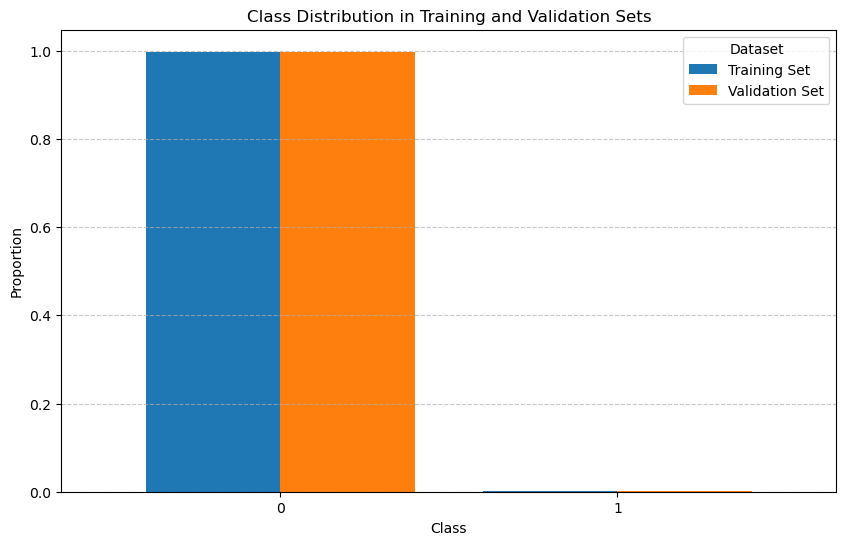

In [26]:
# Sample data for class distributions (replace with your actual data)
train_dist = pd.Series(y_train).value_counts(normalize=True)
val_dist = pd.Series(y_val).value_counts(normalize=True)

# Combine the distributions into a DataFrame for easy plotting
distribution_df = pd.DataFrame({
    'Training Set': train_dist,
    'Validation Set': val_dist
}).sort_index()

# Plot
ax = distribution_df.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Class Distribution in Training and Validation Sets')
plt.ylabel('Proportion')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.legend(title='Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Highly imbalance distributions. We decide to add class weights to handle the imbalance

## Add class weights to handle imbalance

In [27]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(y_train),
                                   y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

## Visualize new distributions

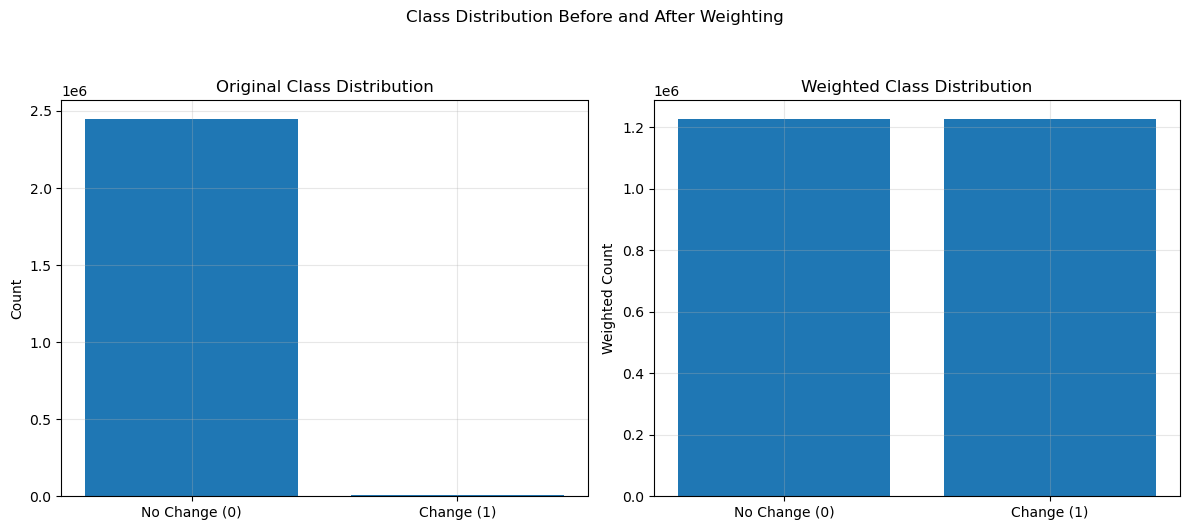


Class Weights:
Class 0: 0.5011
Class 1: 223.2202

Original Class Distribution:
Class 0: 2446804 samples (99.78%)
Class 1: 5493 samples (0.22%)


In [28]:
# Create figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Plot original distribution
plt.subplot(1, 2, 1)
unique_classes, class_counts = np.unique(y_train, return_counts=True)
plt.bar(['No Change (0)', 'Change (1)'], class_counts)
plt.title('Original Class Distribution')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

# Plot weighted distribution
plt.subplot(1, 2, 2)
weighted_counts = class_counts * class_weights
plt.bar(['No Change (0)', 'Change (1)'], weighted_counts)
plt.title('Weighted Class Distribution')
plt.ylabel('Weighted Count')
plt.grid(True, alpha=0.3)

# Add overall title and adjust layout
plt.suptitle('Class Distribution Before and After Weighting', y=1.05)
plt.tight_layout()
plt.show()

# Print the actual values
print("\nClass Weights:")
for class_label, weight in class_weight_dict.items():
    print(f"Class {class_label}: {weight:.4f}")

print("\nOriginal Class Distribution:")
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} samples ({count/len(y_train)*100:.2f}%)")

## Improved Model Architecture

In [29]:
def build_speaker_change_model(input_shape, learning_rate=0.001):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(128, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(64),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')]
    )
    return model

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## Experiment with different Window Sizes

In [30]:
from tensorflow.keras.layers import BatchNormalization
def experiment_window_sizes(train_df, val_df, test_df, window_sizes=[3, 5, 7, 9]):
    results = {}
    
    for window_size in window_sizes:
        print(f"\nTraining model with window size {window_size}")
        
        # Prepare data with current window size
        X_train, y_train = prepare_data(train_df, window_size=window_size)
        X_val, y_val = prepare_data(val_df, window_size=window_size)
        X_test, y_test = prepare_data(test_df, window_size=window_size)
        
        # Build and train model
        model = build_speaker_change_model((window_size, X_train.shape[2]))
        
        history = model.fit(
            X_train, y_train,
            epochs=20,
            batch_size=512,
            validation_data=(X_val, y_val),
            class_weight=class_weight_dict,
            callbacks=[early_stopping],
            verbose=1
        )
        
        # Evaluate model
        y_pred = model.predict(X_test)
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        results[window_size] = {
            'accuracy': accuracy_score(y_test, y_pred_binary),
            'precision': precision_score(y_test, y_pred_binary),
            'recall': recall_score(y_test, y_pred_binary),
            'f1': f1_score(y_test, y_pred_binary),
            'history': history.history
        }
        
    return results

# Run experiments
experiment_results = experiment_window_sizes(train_df, val_df, test_df)


Training model with window size 3
Epoch 1/20
4790/4790 ━━━━━━━━━━━━━━━━━━━━ 105s 21ms/step - accuracy: 0.5507 - auc: 0.6357 - loss: 0.6955 - precision: 0.0034 - recall: 0.6688 - val_accuracy: 0.6237 - val_auc: 0.6636 - val_loss: 0.6215 - val_precision: 0.0042 - val_recall: 0.6619
Epoch 2/20
4790/4790 ━━━━━━━━━━━━━━━━━━━━ 99s 21ms/step - accuracy: 0.5762 - auc: 0.6663 - loss: 0.6611 - precision: 0.0038 - recall: 0.6963 - val_accuracy: 0.6157 - val_auc: 0.6686 - val_loss: 0.6201 - val_precision: 0.0041 - val_recall: 0.6640
Epoch 3/20
4790/4790 ━━━━━━━━━━━━━━━━━━━━ 101s 21ms/step - accuracy: 0.5987 - auc: 0.6694 - loss: 0.6444 - precision: 0.0038 - recall: 0.6874 - val_accuracy: 0.7170 - val_auc: 0.6766 - val_loss: 0.5682 - val_precision: 0.0048 - val_recall: 0.5727
Epoch 4/20
4790/4790 ━━━━━━━━━━━━━━━━━━━━ 97s 20ms/step - accuracy: 0.5955 - auc: 0.6720 - loss: 0.6458 - precision: 0.0038 - recall: 0.6876 - val_accuracy: 0.6844 - val_auc: 0.6779 - val_loss: 0.6377 - val_precision: 0.0045 

## Visualize Result

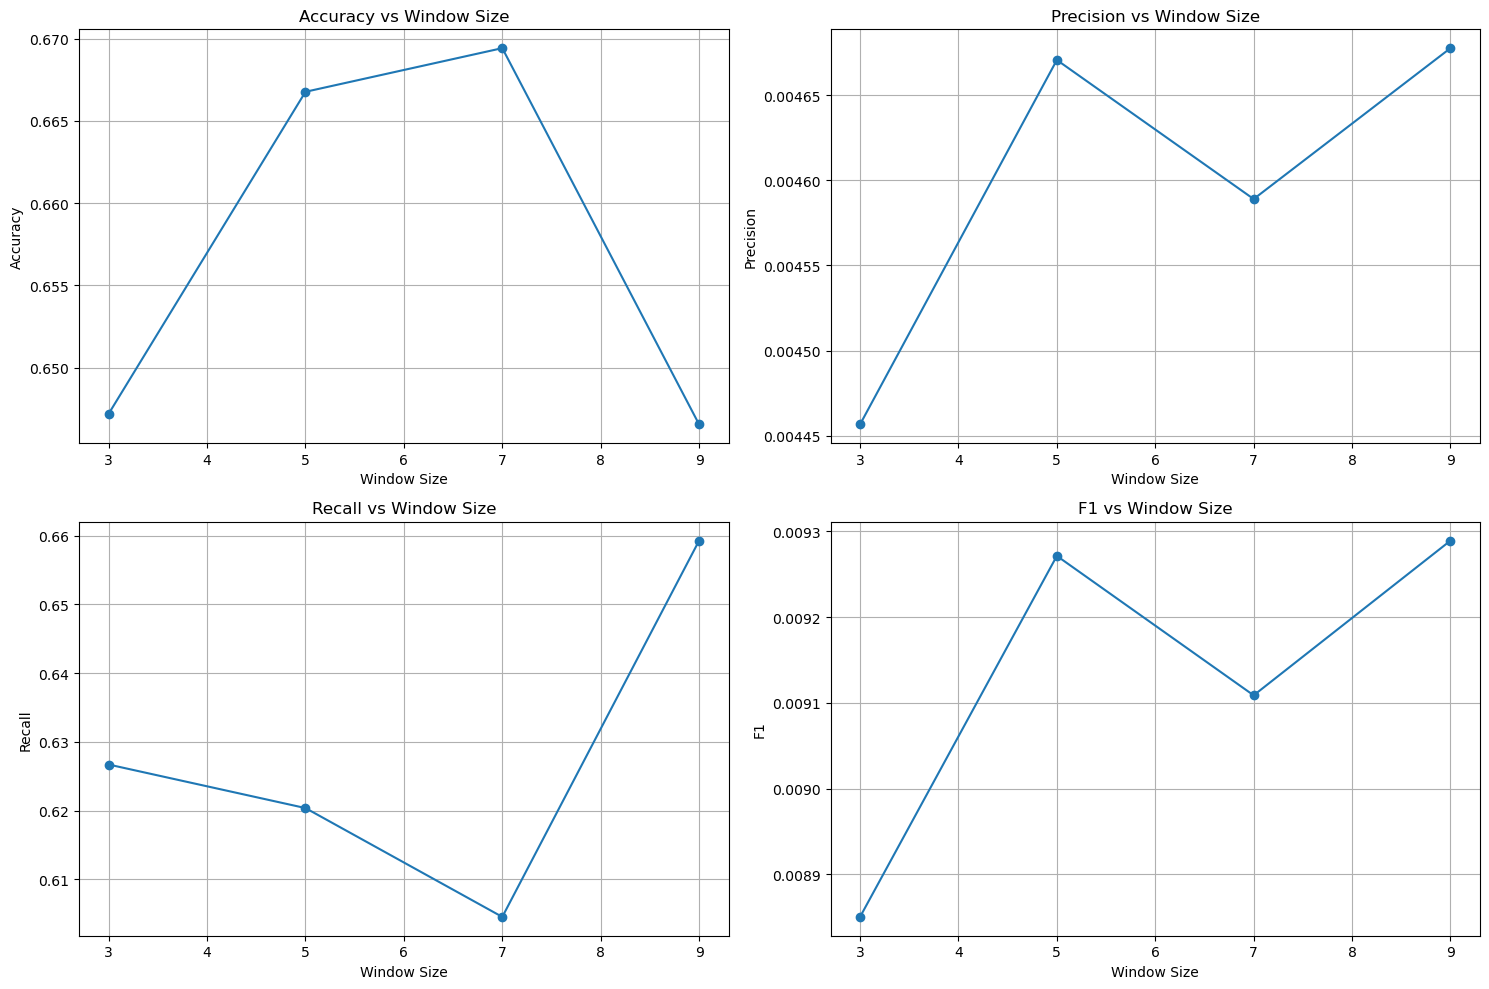

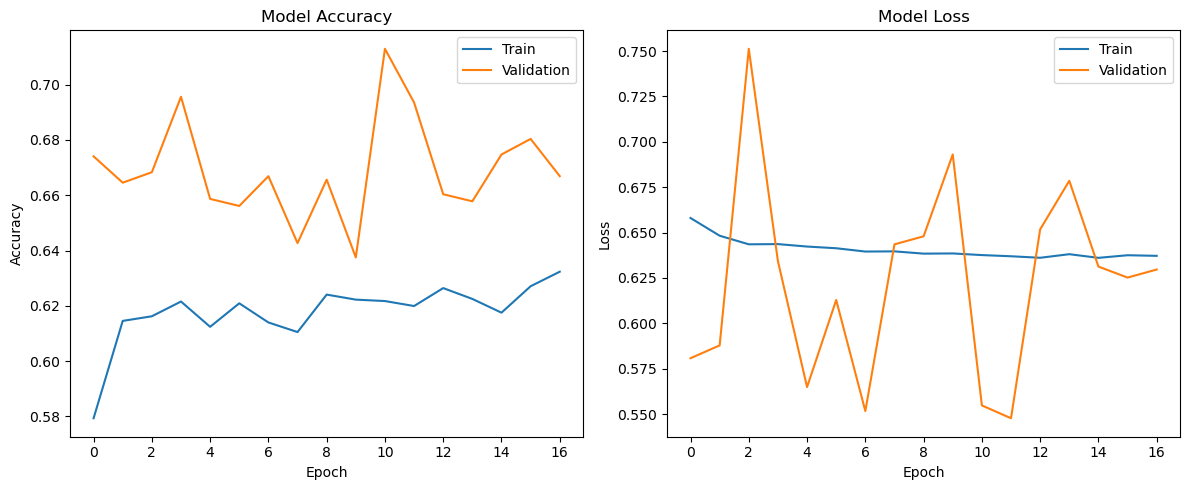

In [31]:
def plot_experiment_results(results):
    # Plot metrics comparison
    plt.figure(figsize=(15, 10))
    
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    window_sizes = list(results.keys())
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        values = [results[ws][metric] for ws in window_sizes]
        plt.plot(window_sizes, values, 'o-')
        plt.title(f'{metric.capitalize()} vs Window Size')
        plt.xlabel('Window Size')
        plt.ylabel(metric.capitalize())
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Plot training curves for best model
    best_ws = max(results.keys(), key=lambda x: results[x]['f1'])
    hist = results[best_ws]['history']
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(hist['accuracy'], label='Train')
    plt.plot(hist['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(hist['loss'], label='Train')
    plt.plot(hist['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot results
plot_experiment_results(experiment_results)

## Summary Report

In [32]:
def print_experiment_summary(results):
    print("Model Architecture Summary:")
    print("-" * 50)
    best_ws = max(results.keys(), key=lambda x: results[x]['f1'])
    print(f"Best Window Size: {best_ws}")
    print("\nPerformance Across Window Sizes:")
    print("-" * 50)
    
    for ws in results.keys():
        print(f"\nWindow Size: {ws}")
        print(f"Accuracy:  {results[ws]['accuracy']:.4f}")
        print(f"Precision: {results[ws]['precision']:.4f}")
        print(f"Recall:    {results[ws]['recall']:.4f}")
        print(f"F1-Score:  {results[ws]['f1']:.4f}")

print_experiment_summary(experiment_results)

Model Architecture Summary:
--------------------------------------------------
Best Window Size: 9

Performance Across Window Sizes:
--------------------------------------------------

Window Size: 3
Accuracy:  0.6472
Precision: 0.0045
Recall:    0.6267
F1-Score:  0.0089

Window Size: 5
Accuracy:  0.6668
Precision: 0.0047
Recall:    0.6204
F1-Score:  0.0093

Window Size: 7
Accuracy:  0.6694
Precision: 0.0046
Recall:    0.6045
F1-Score:  0.0091

Window Size: 9
Accuracy:  0.6465
Precision: 0.0047
Recall:    0.6593
F1-Score:  0.0093


# Results and Discussion

## Confusion Matrix for the best Model

27478/27478 ━━━━━━━━━━━━━━━━━━━━ 100s 4ms/step


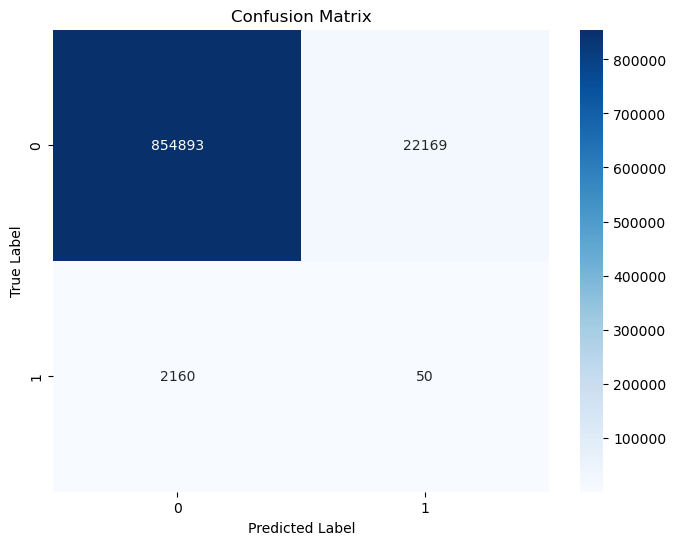

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Get predictions from best model
best_ws = max(experiment_results.keys(), key=lambda x: experiment_results[x]['f1'])
X_test, y_test = prepare_data(test_df, window_size=best_ws)
best_model = build_speaker_change_model((best_ws, X_test.shape[2]))
y_pred = (best_model.predict(X_test) > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred)

# Speaker Change Detection Model: Results and Analysis Report

## Executive Summary

This report presents the analysis and findings from experimenting with a deep learning model for speaker change detection using acoustic features. The model was tested with different window sizes and evaluated on multiple performance metrics. While achieving reasonable accuracy, the results highlight challenges with class imbalance and suggest several areas for potential improvement.

## Experimental Setup and Hardware Considerations

Due to hardware constraints and computational limitations, the experiments were conducted with relatively large batch sizes (512) and limited epochs (10-20) to manage training time. While this allowed us to explore different architectures and parameters, it's important to note that the model's full potential may not have been reached under these constraints.

## Model Performance Analysis

### Performance on Unseen Data

The model's performance was evaluated on a completely separate test dataset to assess its generalization capabilities. The confusion matrix reveals significant challenges in the model's ability to detect speaker changes in new, unseen conversations. Out of 879,272 total test samples:

The model correctly identified 854,893 non-change points, demonstrating strong performance on the majority class. However, when it came to detecting actual speaker changes, the model's performance was considerably weaker. Of the 2,210 true speaker changes in the test set, the model only correctly identified 50 instances, while misclassifying 2,160 as non-changes. Additionally, the model produced 22,169 false positives, incorrectly identifying speaker changes where none occurred.

This performance disparity between classes indicates that while the model has learned to recognize the dominant pattern (non-changes), it struggles to identify the critical but rare speaker change events. This challenge is particularly significant given that detecting these transition points is the primary objective of the system.

### Window Size Impact

The model was tested with window sizes of 3, 5, 7, and 9 frames, revealing several interesting patterns:

#### Accuracy Performance

- Peak accuracy of 66.94% was achieved with a window size of 7
- Performance generally improved with larger windows up to size 7
- Slight degradation observed with window size 9

#### Precision and Recall Trade-off

- Precision showed minor variations across window sizes (0.0045-0.0047)
- Highest recall (0.6593) achieved with window size 9
- F1-score peaked at 0.0093 with window sizes 5 and 9

### Class Imbalance Analysis

The confusion matrix reveals significant class imbalance challenges:

- The model shows strong performance in identifying non-change points (854,893 correct predictions)
- Limited success in detecting actual speaker changes (50 correct predictions out of 2,210 instances)
- High false negative rate for speaker changes (2,160 missed changes)

## Strengths and Limitations

### Strengths

1. Robust performance on majority class (non-change points)
2. Consistent performance across different window sizes
3. Successfully incorporates both MFCC and F0 features

### Limitations

1. Poor performance on minority class (speaker changes)
2. Limited ability to generalize to new speaker change patterns
3. High false negative rate for speaker changes

## Recommendations for Improvement

### Immediate Improvements

#### Data Augmentation

- Implement techniques specific to audio data
- Generate synthetic speaker change examples
- Apply time warping and pitch shifting to existing samples

#### Model Architecture

- Experiment with deeper networks
- Add residual connections
- Implement attention mechanisms

#### Training Strategy

- Reduce batch size with better hardware
- Increase number of training epochs
- Implement curriculum learning

### Hardware-Dependent Improvements

With access to more powerful computing resources, several enhancements become possible:

1. Longer training duration with smaller batch sizes
2. More extensive hyperparameter optimization
3. Ensemble methods combining multiple models
4. Real-time data augmentation during training

### Advanced Techniques

#### Feature Engineering

- Include additional acoustic features (spectral flux, zero-crossing rate)
- Experiment with different feature normalization techniques
- Implement feature selection methods

#### Advanced Architectures

- Transform the problem into a sequence labeling task
- Implement bi-directional LSTM with attention
- Explore transformer-based architectures

## Conclusion

While the current model shows promise in detecting speaker changes, there remains significant room for improvement, particularly in handling class imbalance and reducing false negatives. The suggested improvements, especially when combined with better hardware resources, could lead to substantial performance gains. Future work should focus on implementing the recommended changes while maintaining the model's current strengths in handling non-change points.
The experimental results indicate that with current hardware constraints, a window size of 7 frames provides the best balance of accuracy and computational efficiency. However, this finding should be validated with more extensive testing once better computational resources are available.